#### Simulating Oliver's consolidation task

Consolidation can be thought of as training a neocortical generative / predictive model on replayed hippocampal memories. For sequential data, the generative model could correspond to an autoregressive sequence model like GPT-2 that learns to predict the next item in the sequence (by minimising the prediction error on sequences from the training data). The stimuli for Oliver's task can be represented as sequences of form 'START: yellow fruit, STOP: red, REWARD: animal, SEQUENCE: yellow fruit (-1), green animal (2), red animal (2)', which makes it straightforward to train GPT-2.

This notebook simulates the task as follows:
* Pre-train model so that it learns the *rules* of task
* Train on stimuli for task, representing consolidation
* Compare generative model accept / reject performance before and after consolidation

#### Details

Pre-train model on arbitrary stimuli, to model learning the rules of the task. After this stage of training, the model can be given a prompt with randomly chosen stimuli / conditions, e.g. 'START: blue chair, STOP: sad, REWARD: bug, SEQUENCE:', and generate a sequence consistent with the rules, e.g. 'blue chair (-1), sad bug (2)'. But the model knows nothing about the task stimuli or their order. This is supposed to be equivalent to the participant at the point they pass the rules quiz, prior to experiencing the stimuli.

I ran the simulation for reward and transition revaluation separately (so there was enough data in each case - I could do both at once though, there'd just be less data to train on):
* Reward revaluation: train on 2/3 reward categories in each trial, test on held-out reward category. Repeat n times, each time with a random stimuli order and a random reward condition.
* Transition revaluation: train on 2/3 stop colours in each trial, test on held-out transition category. Repeat n times, each time with a random stimuli order and a random stop condition.

Note that this is more training data than in Oliver's task, as discussed.

The accept / reject task is modelled as follows:
* Get the predicted sequence from the model given an input of form 'START: yellow animal, STOP: red, REWARD: animal, SEQUENCE:'
* Extract the predicted rewards (any numbers in round brackets)
* If predicted reward sum > 0, accept, and if predicted reward sum <= 0, reject
* Calculate the accuracy of the accept / reject decisions by comparing with the real sequences
* There are 81/3 = 27 test sequences in each case. Of these 9 are of length 1 (with the stop condition met by the start stimulus). I excluded these as these don't require any learning of the sequence to predict the reward.
* As described above, there were multiple trials for each of the reward and transition revaluation tasks.

#### Results

The result is that the generative model (pre-trained on the rules of the task) learns the sequence of stimuli through consolidation, so that it can do reward and transition revaluation fairly well. 

I haven't modelled the hippocampal memory prior to consolidation, I've just shown that the generative model can learn the tasks (through causal sequence modelling, i.e. 'prediction error minimisation' on stored 'memories'). As discussed you might expect reward revaluation soon after encoding to be easier - you can retrieve a (non-consolidated) sequence from HPC then infer the rewards for a different reward category, whereas transition revaluation requires knowledge of transition probabilities to be extracted from the memories.

#### Installation / imports:

In [ ]:
! pip install git+https://github.com/huggingface/transformers
! pip install accelerate evaluate wonderwords simpletransformers

In [1]:
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import string
import os
import re
import glob
import torch
from wonderwords import RandomWord
import os
import gc
import pickle

# import functions from another Python file in my code:
from gpt import GPT

os.environ["WANDB_DISABLED"] = "true"

Matplotlib is building the font cache; this may take a moment.


#### Pre-train model on arbitrary stimuli to learn rules of task

The get_random_stimuli() function generates a random set of nouns and adjectives (3 for each by default). The stimuli are all possible combinations, e.g. for the adjectives ABC and nouns DEF, the stimuli are AD, AE, AF, BD, etc. The get_stimuli() function is the equivalent but for Oliver's task stimuli. 

The get_reward() function predicts reward points for a sequence of stimuli. Given a list of stimuli in random order, the stimulus at which the sequence starts, the adjective at which the sequence ends, and the noun that gives 2 points of reward, the function returns a list of stimuli and their rewards, e.g. ['small chair (2)', 'angry chair (2)', 'metal spoon (-1)'].

In [2]:
def get_random_stimuli(n=3):
    r = RandomWord()
    adjectives = [r.word(include_parts_of_speech=["adjectives"]).replace(" ", "_") for _ in range(n)]
    nouns = [r.word(include_parts_of_speech=["nouns"]).replace(" ", "_") for _ in range(n)]

    stimuli = []
    for i, noun in enumerate(nouns):
        for adjective in adjectives:
            stimuli.append(f"{adjective} {noun}")

    return stimuli, nouns, adjectives

def get_stimuli():
    stimuli = ["red animal", 
               "green animal", 
               "yellow animal", 
               "red vehicle", 
               "green vehicle", 
               "yellow vehicle", 
               "red fruit", 
               "green fruit", 
               "yellow fruit"]
    
    objects = [word.split()[1] for word in stimuli]
    colours = list(set([word.split()[0] for word in stimuli]))
    return stimuli, objects, colours

def shuffle_stimuli(stimuli):
    random.shuffle(stimuli)
    return stimuli

def get_reward(stimuli, start, stop, reward):
    """Predict reward points for a sequence of stimuli.
    
    Args:
        stimuli (list): List of stimuli in random order.
        start (str): Object at which the sequence starts.
        stop (str): Colour at which the sequence ends.
        reward (str): Category of object that brings 2 points of reward.

    Returns:
        list of str: Reward points descriptions for the sequence.
    """
    points = []
    sequence_started = False
    
    index = 0  # start index
    while True:
        stim = stimuli[index % len(stimuli)]
        colour, obj = stim.split()

        if not sequence_started:
            if stim == start:
                sequence_started = True
            else:
                index += 1
                continue

        if obj == reward:
            points.append(f"{stim} (2)")
        else:
            points.append(f"{stim} (-1)")

        if colour == stop:
            break

        index += 1  # move to the next stimulus

    return points

We now generate training and test data for the pre-training.

In [ ]:
training_strs = []
for i in range(300):
    stimuli, objects, colours = get_random_stimuli()
    stimuli = shuffle_stimuli(stimuli)
    print(f"Stimuli: {stimuli}")
    for stim in stimuli:
        for colour in colours:
            for obj in objects:
                start = stim
                stop = colour
                reward = obj
                instruction_str = f"START: {start}, STOP: {stop}, REWARD: {reward},"
                points = get_reward(stimuli, start, stop, reward)
                training_str = instruction_str + " SEQUENCE: " + ", ".join(points)
                training_strs.append(training_str)

testing_strs = []
for i in range(10):
    stimuli, objects, colours = get_random_stimuli()
    stimuli = shuffle_stimuli(stimuli)
    print(f"Stimuli: {stimuli}")
    for stim in stimuli:
        for colour in colours:
            for obj in objects:
                start = stim
                stop = colour
                reward = obj
                instruction_str = f"START: {start}, STOP: {stop}, REWARD: {reward},"
                points = get_reward(stimuli, start, stop, reward)
                testing_str = instruction_str + " SEQUENCE: " + ", ".join(points)
                testing_strs.append(testing_str)

print(f"{len(training_strs)} sequences of arbitrary stimuli generated for pre-training.")

The function below runs a script to fine-tune a gpt-2 model on the arbitrary stimuli.

The name_or_path argument is which model to fine-tune from. In the pre-training stage, this will be set to 'gpt2'.

In [ ]:
def train_model_script(name_or_path='rule_model', 
                       num_epochs=3,
                       output_dir='./clm_script'):
    torch.cuda.empty_cache()
    gc.collect()
    ! python ./transformers/examples/pytorch/language-modeling/run_clm.py \
        --model_name_or_path {name_or_path} \
        --train_file {os.path.join(output_dir, 'train.txt')} \
        --validation_file {os.path.join(output_dir, 'train.txt')} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'steps' \
        --save_steps 100
    

Shuffle the data, write it to train.txt and test.txt files, and train gpt2:

In [ ]:
!rm -rf rule_model
!mkdir rule_model

# random.shuffle(training_strs)
# random.shuffle(testing_strs)

text_file = open("rule_model/train.txt", "w")
n = text_file.write('\n'.join(training_strs))
text_file.close()

text_file = open("rule_model/test.txt", "w")
n = text_file.write('\n'.join(testing_strs))
text_file.close()

train_model_script(name_or_path='gpt2', output_dir='rule_model', num_epochs=5)

Test the output with some random start / stop / reward conditions not seen in the training data to see if it's learned the rules:

In [6]:
model = GPT(base_model='rule_model')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Can the model generalise the rules to new stimuli?

In [7]:
out = model.continue_input("START: blue chair, STOP: sad, REWARD: bug, SEQUENCE:", do_sample=True)
print(out)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: blue chair, STOP: sad, REWARD: bug, SEQUENCE: blue chair (-1), blue raincover (-1), sad raincover (-1)
START: blue raincover, STOP: blue, REWARD: congo, SEQUENCE: blue raincover (-1)
START: blue raincover, STOP: blue, REWARD: raincover, SEQUENCE: blue raincover (2)
START: blue raincover, STOP: blue, REWARD: congo, SEQUENCE: blue raincover (-1)
START: blue raincover, STOP: happy, REWARD: raincover, SEQUENCE: blue raincover (2), sad raincover (2), blue congo (-1), happy congo (-1)
START: blue raincover, STOP: happy, REWARD: congo, SEQUENCE: blue raincover (-1), sad raincover (-1),


#### 'Retrieval augmented generation'

Can the generative network's outputs be conditioned on hippocampal sequences (inspired by retrieval augmented generation), to support some degree of generalisation soon after encoding?

In [34]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def get_seqs_RAG(base_dir='clm_script_0', test_type='reward'):
    with open(os.path.join(base_dir, f'test_{test_type}.txt')) as f:
        seqs = f.readlines()
        seqs = [s.replace('\n', '') for s in seqs]
        test_seqs = list(set(seqs))

    with open(os.path.join(base_dir, f'train.txt')) as f:
        seqs = f.readlines()
        seqs = [s.replace('\n', '') for s in seqs]
        train_seqs = list(set(seqs))
    
    return train_seqs, test_seqs

def reward_test_RAG(base_dir = 'clm_script_0'):
    train_seqs, test_seqs = get_seqs_RAG(base_dir=base_dir, test_type='reward')

    if 'REWARD: fruit' in ''.join(test_seqs):
        reward = 'fruit'
    if 'REWARD: vehicle' in ''.join(test_seqs):
        reward = 'vehicle'
    if 'REWARD: animal' in ''.join(test_seqs):
        reward = 'animal'
    print(reward)

    result_bools = []
    # reward revaluation test:
    for test in test_seqs:
        # print(test)
        partial_test = test[0:test.index('REWARD')]
        train_examples = [t for t in train_seqs if partial_test in t][0:1]
        continuation = model.continue_input("\n".join(train_examples) + '\n' + partial_test + f'REWARD: {reward}, SEQUENCE:',
                                            do_sample=True)
        start_ind = find_nth(continuation, 'SEQUENCE', len(train_examples) + 1)
        end_ind = find_nth(continuation, 'START', len(train_examples) + 2)
        
        true_a_v_r = get_accept_reject_choice(test)
        pred_a_v_r = get_accept_reject_choice(continuation[start_ind:end_ind])
        if true_a_v_r == pred_a_v_r:
            result_bools.append(1)
        else:
            result_bools.append(0)
    return result_bools
        
def transition_test_RAG(base_dir = 'clm_script_0'):
    train_seqs, test_seqs = get_seqs_RAG(base_dir=base_dir, test_type='transition')

    if 'STOP: red' in ''.join(test_seqs):
        stop = 'red'
    if 'STOP: green' in ''.join(test_seqs):
        stop = 'green'
    if 'STOP: yellow' in ''.join(test_seqs):
        stop = 'yellow'
    print(stop)

    result_bools = []
    # transition revaluation test:
    for test in test_seqs:
        # print(test)
        start_criterion = test[test.index('START'):test.index('STOP')]
        reward_criterion = test[test.index('REWARD'):test.index('SEQUENCE')]
        train_examples = [t for t in train_seqs if start_criterion in t and reward_criterion in t]
        continuation = model.continue_input("\n".join(train_examples) + '\n' + test[0:test.index('SEQUENCE')] + 'SEQUENCE:',
                                            do_sample=True)
        start_ind = find_nth(continuation, 'SEQUENCE', len(train_examples) + 1)
        end_ind = find_nth(continuation, 'START', len(train_examples) + 2)

        true_a_v_r = get_accept_reject_choice(test)
        pred_a_v_r = get_accept_reject_choice(continuation[start_ind:end_ind])
        if true_a_v_r == pred_a_v_r:
            result_bools.append(1)
        else:
            result_bools.append(0)
    return result_bools

all_transition = []
all_reward = []
for i in range(10):
    res = transition_test_RAG(base_dir = f'clm_script_{i}')
    all_transition.append(res)
    res = reward_test_RAG(base_dir = f'clm_script_{i}')
    all_reward.append(res)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


yellow


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow vehicle (-1)
[-1, -1]
 green fruit (-1), yellow vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1)
[2, -1]
 red animal (2), yellow fruit (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green vehicle (2), yellow animal (-1)
[2, 2, -1]
 red vehicle (2), green SUV (-1), yellow SUV (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow vehicle (2)
[-1, 2]
 green fruit (-1), yellow vehicle (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), yellow animal (-1)
[2, -1]
 green vehicle (2), yellow animal (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1), yellow animal (2)
[-1, -1, 2]
 red car (-1), green car (-1), green rat (-1), yellow rat (-1)

[-1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), yellow vehicle (-1)
[-1, -1, -1]
 red fruit (-1), green apple (-1), yellow apple (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), yellow vehicle (2)
[-1, -1, 2]
 red fruit (-1), green fruit (-1), yellow SUV (2)

[-1, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red vehicle (2), green vehicle (2), yellow animal (-1)
[-1, 2, 2, -1]
 green animal (-1), red vehicle (2), yellow car (2)

[-1, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red vehicle (-1), green vehicle (-1), yellow animal (2)
[2, -1, -1, 2]
 green animal (2), red car (-1), green bangle (-1), yellow bangle (-1)

[2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (2)
[-1, 2]
 green vehicle (-1), yellow animal (2)

[-1, 2]
fruit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 red fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
 green vehicle (-1), yellow animal (-1), red animal (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red vehicle (-1)
[-1, -1]
 green animal (-1), red SUV (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 green fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1)
[-1, -1]
 red vehicle (-1), green vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green animal (-1)
[-1, -1]
 yellow car (-1), green animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
 red animal (-1), yellow fruit (2), red fruit (2), green substance (-1)

[-1, 2, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green substance (-1)

[-1, -1, 2, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
 yellow fruit (2), red fruit (2), green apple (2)

[2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), red fruit (2)
[2, 2]
 yellow fruit (2), red apple (2)

[2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red animal (-1)
[-1, -1]
 yellow animal (-1), red animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)

[2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2)
[2, 2]
 red fruit (2), green fruit (2)

[2, 2]
green


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red animal (-1), yellow fruit (2), green animal (-1)
[-1, -1, 2, -1]
 red vehicle (-1), red animal (-1), yellow fruit (2), green carol (-1)

[-1, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 red fruit (-1), green substance (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow vehicle (-1), red fruit (2), green fruit (2)
[-1, -1, 2, 2]
 yellow animal (-1), yellow vehicle (-1), red apple (2), green apple (2)

[-1, -1, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
 yellow vehicle (-1), red fruit (-1), green elk (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow vehicle (-1), red fruit (-1), green fruit (-1)
[2, -1, -1, -1]
 yellow animal (2), yellow vehicle (-1), red fruit (-1), green tree (-1)

[2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 green fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2)
[-1, 2]
 yellow fruit (-1), green animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green animal (-1)
[2, -1]
 yellow fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (2), green fruit (2)
[-1, 2, 2]
 yellow vehicle (-1), red fruit (2), green carol (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red animal (2), yellow fruit (-1), green animal (2)
[-1, 2, -1, 2]
 red vehicle (-1), red animal (2), yellow apple (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (-1), yellow rain (2), yellow rain (2), yellow rain (2), yellow rain (2), yellow rain (2), yello
[-1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2), green animal (-1)
[-1, 2, -1]
 red animal (-1), yellow fruit (2), yellow pharmacopoeia (-1), green pharmacopoeia (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2)
[2]
 green animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1), green animal (2)
[2, -1, 2]
 red animal (2), yellow fruit (-1), green apple (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2)
[2, 2]
 red fruit (2), green apple (2)

[2, 2]
vehicle


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow vehicle (2), red fruit (-1)
[-1, 2, -1]
 yellow animal (-1), yellow vehicle (2), red fruit (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), red animal (-1), yellow fruit (-1)
[2, -1, -1]
 red vehicle (2), red animal (-1), yellow fruit (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (2), red vehicle (2)
[-1, 2, 2]
 green fruit (-1), green vehicle (2), red vehicle (2)

[-1, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
[2, 2, -1, -1]
 green vehicle (2), red car (2), red animal (-1), yellow fruit (-1)

[2, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red vehicle (2)
[2, 2]
 green vehicle (2), red vehicle (2)

[2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1), yellow fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (-1), yellow animal (-1), yellow vehicle (2), red fruit (-1)
[-1, -1, -1, 2, -1]
 yellow fruit (-1), green animal (-1), yellow animal (-1), yellow vehicle (2), red fruit (-1)

[-1, -1, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red fruit (-1)
[2, -1]
 yellow vehicle (2), red fruit (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1)
[-1, -1]
 green animal (-1), yellow animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
[-1, -1, 2, 2, -1, -1]
 red fruit (-1), green apple (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)

[-1, -1, 2, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1), yellow vehicle (2), red fruit (-1)
[-1, -1, 2, -1]
 green animal (-1), yellow animal (-1), yellow car (2), red fruit (-1)

[-1, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 Suffolk county (-1), yellow county (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
[-1, 2, 2, -1, -1]
 green fruit (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)

[-1, 2, 2, -1, -1]
red


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 red fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red animal (-1)
[-1, -1]
 green animal (-1), red animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[-1, -1, -1, -1]
 yellow animal (-1), yellow fruit (-1), green animal (-1), red car (2)

[-1, -1, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[2, -1, 2, -1, -1]
 green fruit (2), yellow animal (-1), yellow rhinoceros (-1), green rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhino
[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), yellow vehicle (2), green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[2, 2, -1, -1, -1, -1, -1]
 green vehicle (2), yellow vehicle (2), yellow SUV (-1), yellow SUV (-1), yellow reverse (-1), green reverse (-1), yellow reverse (-1)

[2, 2, -1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[2, -1, -1, -1, -1, -1]
 yellow vehicle (2), green fruit (-1), yellow car (2), green peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (-1), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yellow peach (2), yello
[2, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow vehicle (-1), green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[-1, -1, 2, -1, 2, -1, -1]
 green vehicle (-1), yellow vehicle (-1), yellow peach (2), yellow peach (2), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (-1), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yellow SUV (2), yello
[-1, -1, 2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[-1, -1, -1, -1, -1]
 green fruit (-1), yellow animal (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (2), yellow tree (2), yellow tree (2), yellow tree (2), yellow tree (2), yellow tree (2), yellow tree (2)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red animal (-1)
[-1, -1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[-1, 2, -1, 2, -1, -1]
 yellow vehicle (-1), green fruit (2), yellow storage (-1), green storage (-1), red storage (-1)

[-1, 2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (-1), red animal (-1)
[-1, -1, -1]
 yellow fruit (-1), green animal (-1), yellow carport (-1), yellow carport (-1), red carport (-1)

[-1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green animal (-1), red animal (-1)
[2, -1, -1]
 yellow fruit (2), green animal (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhino
[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[-1, 2, -1, -1]
 yellow animal (-1), yellow fruit (2), green animal (-1), yellow peach (-1), green peach (2), red bird (-1)

[-1, 2, -1, -1, 2, -1]
animal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow fruit (-1), green animal (2)
[2, -1, 2]
 yellow animal (2), yellow fruit (-1), green animal (2)

[2, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2)
[-1, 2]
 yellow fruit (-1), green animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (-1)
[-1, -1]
 yellow vehicle (-1), green fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
 green vehicle (-1), yellow car (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (2)
[-1, 2]
 green apple (-1), yellow animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red fruit (-1), green vehicle (-1)
[-1, -1, -1]
 red vehicle (-1), red fruit (-1), green vehicle (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1)
[2, -1, -1, -1]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1)

[2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2)
[2]
 green animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (2)

[2, -1, -1, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)

[2, 2, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
 red vehicle (-1), red fruit (-1), green car (-1), yellow vehicle (-1)

[-1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green vehicle (-1)
[-1, -1]
 red fruit (-1), green vehicle (-1)

[-1, -1]
yellow


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1)
[2, -1]
 red animal (2), yellow fruit (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (-1), yellow fruit (-1)
[-1, -1, -1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (2), yellow vehicle (-1)
[-1, 2, -1]
 red vehicle (-1), green trap (-1), yellow trap (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), green fruit (-1), yellow animal (2)
[-1, -1, 2]
 green vehicle (-1), green fruit (-1), yellow animal (2)

[-1, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow carol (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), green fruit (-1), yellow animal (-1)
[2, -1, -1]
 green vehicle (2), green fruit (-1), yellow animal (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green animal (-1), yellow vehicle (2)
[2, -1, 2]
 red vehicle (2), green animal (-1), yellow car (2)

[2, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1), yellow fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow vehicle (2)
[-1, 2]
 green animal (-1), yellow vehicle (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (2)
[-1, 2]
 green fruit (-1), yellow animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow vehicle (-1)
[2, -1]
 green animal (2), yellow vehicle (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (2), yellow fruit (-1)
[-1, 2, -1]
 red fruit (-1), red animal (2), yellow fruit (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (-1)
[-1, -1]
 green fruit (-1), yellow animal (-1)

[-1, -1]
fruit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (2), red animal (-1), yellow fruit (2), green vehicle (-1)
[-1, 2, -1, 2, -1]
 yellow vehicle (-1), red fruit (2), red animal (-1), yellow fruit (2), green vehicle (-1)

[-1, 2, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 red fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (-1)
[-1, -1]
 red vehicle (-1), green animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2), green vehicle (-1)
[-1, 2, -1]
 red animal (-1), yellow fruit (2), green vehicle (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 green fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red vehicle (-1), green animal (-1)
[-1, -1, -1]
 yellow animal (-1), red vehicle (-1), green animal (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green vehicle (-1)
[2, -1]
 yellow fruit (2), green vehicle (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), red animal (-1), yellow fruit (2), green vehicle (-1)
[2, -1, 2, -1]
 red fruit (2), red animal (-1), yellow apple (2), green vehicle (-1)

[2, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
 yellow fruit (2), green vehicle (-1),Recorded car (-1), green fruit (2), yellow animal (-1), red car (-1)

[2, -1, -1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red vehicle (-1)
[-1, -1]
 yellow animal (-1), red vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
 green animal (-1), yellow vehicle (-1), red fruit (2)

[-1, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
 green fruit (2), yellow animal (-1), red vehicle (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (2)
[-1, 2]
 yellow vehicle (-1), red fruit (2)

[-1, 2]
green


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), yellow vehicle (-1), red animal (-1), green vehicle (-1)
[2, -1, -1, -1]
 yellow fruit (2), yellow vehicle (-1), red animal (-1), green car (-1)

[2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (-1)
[-1, -1]
 red vehicle (-1), green animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), yellow vehicle (2), red animal (-1), green vehicle (2)
[-1, 2, -1, 2]
 yellow fruit (-1), yellow vehicle (2), red animal (-1), green car (2)

[-1, 2, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 green fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green vehicle (2)
[-1, 2]
 red animal (-1), green vehicle (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (2), green fruit (2)
[-1, 2, 2]
 yellow animal (-1), red fruit (2), red vinegar (-1), green vinegar (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green vehicle (-1)
[-1, -1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red animal (-1), green vehicle (-1)
[-1, -1, -1]
 yellow vehicle (-1), red animal (-1), yellow grass (-1), green grass (-1)

[-1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red animal (-1), green vehicle (2)
[2, -1, 2]
 yellow car (2), red animal (-1), marked depot (-1), marked depot (-1), green depot (-1)

[2, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green animal (-1)
[2, -1]
 red vehicle (2), green animal (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
 yellow animal (-1), red fruit (-1), red carol (-1), yellow carol (-1), green carol (-1)

[-1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2)
[2, 2]
 red fruit (2), green apple (2)

[2, 2]
animal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), green vehicle (-1), red vehicle (-1), green animal (2), yellow animal (2)
[2, -1, -1, 2, 2]
 red animal (2), green vehicle (-1), red vehicle (2), green animal (2), yellow animal (2)

[2, -1, 2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), yellow fruit (-1)
[-1, -1, -1]
 red fruit (-1), green apple (-1), yellow fruit (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow SUV (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (2), yellow animal (2)
[-1, 2, 2]
 red vehicle (-1), green animal (2), yellow animal (2)

[-1, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), yellow vehicle (-1), red animal (2)
[-1, -1, 2]
 yellow fruit (-1), yellow vehicle (-1), red animal (2)

[-1, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow animal (2)
[2, 2]
 green animal (2), yellow animal (2)

[2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow animal (2), red fruit (-1)
[2, 2, -1]
 green animal (2), yellow animal (2), red fruit (-1)

[2, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red fruit (-1)
[2, -1]
 yellow animal (2), red apple (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow fruit (-1)
[-1, -1]
 green fruit (-1), yellow fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow fruit (-1), yellow vehicle (-1), red animal (2)
[-1, -1, -1, 2]
 green fruit (-1), yellow fruit (-1), yellow vehicle (-1), red animal (2)

[-1, -1, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red SUV (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1)
[-1, -1]
 green vehicle (-1), red vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1), green animal (2), yellow animal (2)
[-1, -1, 2, 2]
 green vehicle (-1), red vehicle (-1), green animal (2), yellow animal (2)

[-1, -1, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red animal (2)
[-1, 2]
 yellow vehicle (-1), red animal (2)

[-1, 2]
green


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2), green fruit (2)
[-1, 2, 2]
 red animal (-1), yellow fruit (2), yellow greenhouse (-1), red greenhouse (-1), yellow greenhouse (-1), green greenhouse (-1)

[-1, 2, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green vehicle (-1)
[-1, -1]
 yellow vehicle (-1), green vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (-1)
[-1, -1]
 red vehicle (-1), green animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red vehicle (-1), green animal (-1)
[-1, -1, -1]
 yellow animal (-1), red car (-1), red crane (-1), yellow crane (-1), green crane (-1)

[-1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 green apple (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red vehicle (2), green animal (-1)
[-1, 2, -1]
 yellow animal (-1), red car (2), yellow frame (-1), green frame (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green fruit (-1)
[-1, -1]
182, yellow fruit (-1), green fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1), green fruit (-1)
[-1, -1, -1]
 red animal (-1), yellow fruit (-1), yellow tree (-1), yellow carport (-1), green tree (-1)

[-1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), yellow vehicle (2), green vehicle (2)
[-1, 2, 2]
 red fruit (-1), yellow vehicle (2), yellow storage (-1), yellow storage (-1), yellow child (-1), green storage (-1)

[-1, 2, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green fruit (2)
[2, 2]
 yellow fruit (2), green fruit (2)

[2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), green vehicle (2)
[2, 2]
 yellow vehicle (2), green vehicle (2)

[2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green animal (-1)
[2, -1]
 red vehicle (2), green animal (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), yellow vehicle (-1), green vehicle (-1)
[2, -1, -1]
 red fruit (2), yellow vehicle (-1), yellow SUV (-1), green SUV (-1)

[2, -1, -1, -1]
animal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1)
[2, -1]
 red animal (2), yellow fruit (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red animal (2), yellow fruit (-1)
[2, 2, -1]
 green animal (2), red animal (2), yellow apple (-1)

[2, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), red fruit (-1), yellow vehicle (-1)
[-1, -1, -1]
 green fruit (-1), red fruit (-1), yellow vehicle (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (2), red animal (2), yellow fruit (-1)
[-1, 2, 2, -1]
 red vehicle (-1), green animal (2), red animal (2), yellow fruit (-1)

[-1, 2, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (2), red vehicle (-1)
[-1, 2, -1]
 green vehicle (-1), yellow animal (2), red vehicle (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red apple (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), yellow vehicle (-1)
[-1, -1]
 red fruit (-1), yellow vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green vehicle (-1), yellow animal (2), red vehicle (-1)
[-1, -1, 2, -1]
 yellow vehicle (-1), green vehicle (-1), yellow animal (2), red vehicle (-1)

[-1, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (2)
[-1, 2]
 green vehicle (-1), yellow animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red animal (2)
[2, 2]
 green animal (2), red animal (2)

[2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red vehicle (-1)
[2, -1]
 yellow animal (2), red vehicle (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), red fruit (-1)
[-1, -1]
 green fruit (-1), red fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green fruit (-1), red fruit (-1)
[-1, -1, -1]
 yellow fruit (-1), green colorlessness (-1), red fruit (-1)

[-1, -1, -1]
yellow


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1]
 green vehicle (-1), red animal (-1), yellow tree (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, 2, -1]
 green fruit (-1), green animal (2), yellow carol (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1, -1]
 red vehicle (-1), green vehicle (-1), yellow refrigerator (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow animal (2)
[2, 2]
 red animal (2), yellow animal (2)

[2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red animal (2), yellow animal (2)
[-1, 2, 2]
 green vehicle (-1), red animal (2), yellow carol (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, -1, 2, -1]
 red fruit (-1), green apple (-1), yellow apple (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), green animal (-1), yellow vehicle (-1)
[2, -1, -1]
 green fruit (2), green animal (-1),ICLE: yellow carol (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow animal (-1)
[-1, -1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow vehicle (-1)
[-1, -1]
 green animal (-1), yellow vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1), red animal (2), yellow animal (2)
[-1, -1, 2, 2]
 red vehicle (-1), green vehicle (-1), green rhinoceros (-1), yellow rhinoceros (-1)

[-1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow vehicle (-1)
[2, -1]
 green animal (2), yellow SUV (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)
[2, 2, -1, -1]
 red fruit (2), green apple (2), green maracas (-1), yellow maracas (-1)

[2, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2)
[2]
 yellow fruit (2)

[2]
vehicle


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[-1, 2, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
 yellow car (2), yellow fruit (-1), red vehicle (2), green vehicle (2)

[2, -1, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
 yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (-1)
[-1, -1]
 yellow animal (-1), red fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red animal (-1)
[2, -1]
 green vehicle (2), red animal (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[-1, -1, 2, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red vehicle (2)
[-1, 2]
 yellow fruit (-1), red vehicle (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 red fruit (-1), green fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
 yellow fruit (-1), red vehicle (2), green vehicle (2)

[-1, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green vehicle (2)
[2, 2]
 red car (2), green vehicle (2)

[2, 2]
red


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 red fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green animal (-1), red fruit (2)
[-1, -1, 2]
 yellow vehicle (-1), green animal (-1), yellow trail (-1), yellow trail (-1), red trail (-1)

[-1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red animal (-1)
[-1, -1]
 green vehicle (-1), red animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), red vehicle (-1)
[2, -1]
 yellow fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), green vehicle (-1), red animal (-1)
[2, -1, -1]
 green fruit (2), green vehicle (-1), red animal (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red fruit (2)
[-1, 2]
 beatsong (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (-1), overt carport (2), overt carport (2), overt carport (2), overt carport (2), overt carport (2), overt carport (
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red fruit (-1)
[2, -1]
 green animal (2), red apple (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red animal (2)
[-1, 2]
 green vehicle (-1), red animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red vehicle (-1)
[-1, -1]
 yellow fruit (-1), red vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1 Taken)

[]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow vehicle (-1), green animal (2), red fruit (-1)
[2, -1, 2, -1]
 yellow animal (2), yellow vehicle (-1), green animal (2), green storage (-1), green storage (-1), red storage (-1)

[2, -1, 2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow vehicle (-1), green animal (-1), red fruit (2)
[-1, -1, -1, 2]
 yellow animal (-1), yellow vehicle (-1), green animal (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (-1), yellow tree (2), yellow tree Corridor (-1), yellow tree (2), yellow tree (2), yellow tree (2), yellow tree (2
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, 2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green animal (2), red fruit (-1)
[-1, 2, -1]
 yellow vehicle (-1), green animal (2), green storage (-1), green storage (-1), yellow storage (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinocero
[-1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (-1), red animal (2)
[-1, -1, 2]
 green fruit (-1), green vehicle (-1), red animal (2)

[-1, -1, 2]
vehicle


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)
[-1, -1, 2, -1, -1]
 red fruit (-1), green fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)

[-1, -1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow SUV (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green apple (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), yellow animal (-1), yellow vehicle (2), green animal (-1)
[2, -1, 2, -1]
 red vehicle (2), yellow animal (-1), yellow vehicle (2), green animal (-1)

[2, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1), red vehicle (2), yellow animal (-1), yellow vehicle (2), green animal (-1)
[-1, -1, 2, -1, 2, -1]
 red animal (-1), yellow fruit (-1), red vehicle (2), yellow animal (-1), yellow vehicle (2), green animal (-1)

[-1, -1, 2, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red animal (-1), yellow fruit (-1)
[2, -1, -1]
 green vehicle (2), red animal (-1), yellow fruit (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red vehicle (2), yellow animal (-1), yellow vehicle (2), green animal (-1)
[-1, 2, -1, 2, -1]
 yellow fruit (-1), red vehicle (2), yellow animal (-1), yellow vehicle (2), green animal (-1)

[-1, 2, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow vehicle (2), green animal (-1)
[-1, 2, -1]
 yellow animal (-1), yellow vehicle (2), green animal (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), green animal (-1)
[2, -1]
 yellow vehicle (2), green animal (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1), yellow fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)
[-1, 2, -1, -1]
 green fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), yellow animal (-1)
[2, -1]
 red vehicle (2), yellow animal (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 red fruit (-1), green fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red fruit (-1), green fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)
[-1, -1, -1, 2, -1, -1]
 green animal (-1), red fruit (-1), green fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)

[-1, -1, -1, 2, -1, -1]
red


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 red fruit (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (2), red fruit (-1)
[-1, 2, -1]
 green vehicle (-1), yellow animal (2), green classification (-1), yellow classification (-1), green classification (-1), yellow greenhouse (-1), red greenhouse (-1)

[-1, 2, -1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (-1), red fruit (2)
[-1, -1, 2]
 green vehicle (-1), yellow animal (-1), yellow storage (-1), yellow storage (-1), yellow storage (-1), yellow nit (-1), purple nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1), yellow nit (-1),ENA (-1), yellow storage (-1), yellow storage (-1), yellow ni
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow fruit (2), yellow vehicle (-1), red vehicle (-1)
[-1, 2, -1, -1]
 green animal (-1), yellow fruit (2), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhinoceros (-1), yellow rhino
[-1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red vehicle (-1)
[-1, -1]
 yellow vehicle (-1), red vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (2)
[-1, 2]
 yellow animal (-1), red apple (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red fruit (-1)
[2, -1]
 yellow animal (2), red fruit (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), yellow vehicle (-1), red vehicle (-1)
[2, -1, -1]
 yellow fruit (2), yellow vehicle (-1), red vehicle (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow fruit (-1), yellow vehicle (-1), red vehicle (-1)
[2, -1, -1, -1]
 green animal (2), yellow fruit (-1), red rhinoceros (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), green animal (-1), yellow fruit (2), yellow vehicle (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
 green fruit (2), green animal (-1), yellow fruit (2)

[2, -1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), yellow vehicle (-1), red vehicle (-1)
[-1, -1, -1]
 yellow fruit (-1), yellow vehicle (-1), red vehicle (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red vehicle (-1)
[-1, -1]
 yellow vehicle (-1), red vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green animal (2), yellow fruit (-1), yellow vehicle (-1), red vehicle (-1)
[-1, 2, -1, -1, -1]
 green fruit (-1), green animal (2), yellow fruit (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (-1), yellow number (2), yellow number (2), yellow number (2), yellow number (2), yellow number (2), yellow number (2), yellow number (2), yellow number (2), yellow number (2)
[-1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
vehicle


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green vehicle (2), yellow animal (-1)
[2, 2, -1]
 red vehicle (2), green vehicle (2), yellow animal (-1)

[2, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), yellow vehicle (2), red vehicle (2), green vehicle (2)
[-1, 2, 2, 2]
 yellow fruit (-1), yellow vehicle (2), red SUV (-1), green SUV (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (-1), red animal (-1), green fruit (-1)
[-1, -1, -1, -1]
 yellow animal (-1), red fruit (-1), red animal (-1), green parcel (-1)

[-1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (-1), green fruit (-1), green animal (-1), yellow fruit (-1)
[-1, -1, -1, -1, -1]
 red fruit (-1), red animal (-1), green fruit (-1), green animal (-1), yellow fruit (-1)

[-1, -1, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green fruit (-1)
[-1, -1]
 red animal (-1), green apple (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), yellow animal (-1)
[2, -1]
 green vehicle (2), yellow animal (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (-1), green fruit (-1)
[-1, -1, -1]
 red fruit (-1), red animal (-1), green fruit (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green animal (-1), yellow fruit (-1)
[-1, -1, -1]
 green fruit (-1), green animal (-1), yellow fruit (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow fruit (-1)
[-1, -1]
 green animal (-1), yellow fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red vehicle (2), green vehicle (2)
[2, 2, 2]
 yellow vehicle (2), red vehicle (2), green vehicle (2)

[2, 2, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green vehicle (2)
[2, 2]
 red vehicle (2), green SUV (-1)

[2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green fruit (-1), green animal (-1), yellow fruit (-1)
[-1, -1, -1, -1]
 red animal (-1), green apple (-1), green car (2), yellow apple (-1)

[-1, -1, 2, -1]
yellow


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), red vehicle (-1), red fruit (2), green vehicle (-1), red animal (-1), yellow fruit (2)
[2, -1, 2, -1, -1, 2]
 green fruit (2), red SUV (-1), yellow SUV (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellow fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red animal (-1), yellow fruit (2)
[-1, -1, 2]
 green vehicle (-1), red animal (-1), yellow hamburger (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), red fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)
[2, -1, 2, -1, -1]
 red vehicle (2), red fruit (-1), green vehicle (2), yellow dessert (-1)

[2, -1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red fruit (2), green vehicle (-1), red animal (-1), yellow fruit (2)
[-1, 2, -1, -1, 2]
 red vehicle (-1), red fruit (2), green car (-1), yellow car (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1)
[-1, -1]
 green animal (-1), yellow animal (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red animal (-1), yellow fruit (-1)
[2, -1, -1]
 green vehicle (2), red animal (-1), yellow hydrogen (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1)
[-1, -1]
 green animal (-1), yellow car (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), red vehicle (2), red fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)
[-1, 2, -1, 2, -1, -1]
 green fruit (-1), red vehicle (2), green overtone (-1), yellow overtone (-1)

[-1, 2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1), yellow apple (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2)
[-1, 2]
 red animal (-1), yellow fruit (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green vehicle (-1), red animal (-1), yellow fruit (2)
[2, -1, -1, 2]
 red fruit (2), green vehicle (-1), red vine (-1), yellow vine (-1)

[2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green vehicle (2), red animal (-1), yellow fruit (-1)
[-1, 2, -1, -1]
 red fruit (-1), green vehicle (2), yellow freight (-1)

[-1, 2, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2)
[2]
 yellow fruit (2)

[2]
animal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow animal (2), yellow vehicle (-1), green fruit (-1), red vehicle (-1)
[2, 2, -1, -1, -1]
 green animal (2), yellow animal (2), yellow vehicle (-1), green fruit (-1), red vehicle (-1)

[2, 2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2), yellow animal (2), yellow vehicle (-1), green fruit (-1), red vehicle (-1)
[-1, 2, 2, -1, -1, -1]
 yellow fruit (-1), green animal (2), yellow animal (2), yellow vehicle (-1), green fruit (-1), red vehicle (-1)

[-1, 2, 2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (-1), red vehicle (-1)
[-1, -1, -1]
 yellow vehicle (-1), green fruit (-1), red vehicle (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), red vehicle (-1)
[-1, -1]
 green fruit (-1), red vehicle (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2)
[-1, 2]
 yellow fruit (-1), green animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red SUV (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (-1)
[-1, -1]
 yellow vehicle (-1), green fruit (-1)

[-1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red animal (2)
[-1, 2]
 green vehicle (-1), red animal (2)

[-1, 2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow vehicle (-1), green fruit (-1)
[2, -1, -1]
 yellow animal (2), yellow SUV (-1), green fruit (-1)

[2, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow vehicle (-1), green fruit (-1), red vehicle (-1)
[2, -1, -1, -1]
 yellow animal (2), yellow vehicle (-1), green fruit (-1), red vehicle (-1)

[2, -1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red fruit (-1), green vehicle (-1)
[-1, -1, -1]
 red Router (-1), red carport (-1), green carport (-1)

[-1, -1, -1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2)
[2]
 green animal (2)

[2]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red fruit (-1)

[-1]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1), green animal (2)
[2, -1, 2]
 red animal (2), yellow fruit (-1), green animal (2)

[2, -1, 2]
 red fruit (-1), green vehicle (-1)
[-1, -1]
 red fruit (-1), green vehicle (-1)

[-1, -1]


In [35]:
np.mean(all_transition)

0.8777777777777778

In [36]:
np.mean(all_reward)

0.9833333333333333

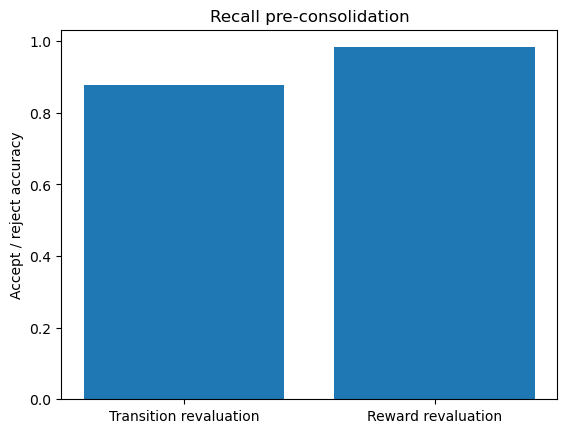

In [38]:
plt.bar(['Transition revaluation', 'Reward revaluation'], 
        [np.mean(all_transition), np.mean(all_reward)])

plt.ylabel('Accept / reject accuracy')
plt.title('Recall pre-consolidation')
plt.savefig('rag.png')
plt.show()

#### Simulate the task

The simulate_task() function runs one trial, for either the transition or reward revaluation task (as set by the leave_out argument):
* First it clears down the model directory.
* Then it shuffles the stimuli for the trial into a random order.
* Then it generates all possible start / stop / reward combinations and gets the sequence for each from the get_reward() function.
* As above, it turns these into strings with format f"START: ..., STOP: ..., REWARD: ..., SEQUENCE: ..."
* In the reward revaluation case, we train on 2/3 of the reward categories in each trial, and test on a held-out reward category. In the transition revaluation case, we train on 2/3 of the stop colours in each trial, and test on a held-out transition category. 
* The training and test data is saved to files, and a model is trained by calling the train_model_script() 

In [ ]:
def simulate_task(leave_out='transition', seed=0):
    random.seed(seed)
    training_strs = []
    
    # get stimuli etc and shuffle them
    stimuli, objects, colours = get_stimuli()
    stimuli = shuffle_stimuli(stimuli)
    print(f"Stimuli: {stimuli}")
    
    for stim in stimuli:
        for colour in colours:
            for obj in objects:
                start = stim
                stop = colour
                reward = obj
                instruction_str = f"START: {start}, STOP: {stop}, REWARD: {reward},"
                points = get_reward(stimuli, start, stop, reward)
                training_str = instruction_str + " SEQUENCE: " + ", ".join(points)
                training_strs.append(training_str)

    if leave_out == 'both':
        random_category = random.choice(objects)
        random_colour = random.choice(colours)
        train_set = [s for s in training_strs if f'REWARD: {random_category}' not in s and f'STOP: {random_colour}' not in s]
        test_set_reward = [s for s in training_strs if f'REWARD: {random_category}' in s and f'STOP: {random_colour}' not in s]
        test_set_transition = [s for s in training_strs if f'REWARD: {random_category}' not in s and f'STOP: {random_colour}' in s]
        test_set_both = [s for s in training_strs if f'REWARD: {random_category}' in s and f'STOP: {random_colour}' in s]

        # oversampling trick to avoid overfitting to sequence order
        train_set = np.random.choice(train_set, 10000).tolist()
        
        output_dir = f'clm_script_{seed}'
        ! rm -rf {output_dir}
        !mkdir {output_dir}
        
        text_file = open(os.path.join(output_dir, 'train.txt'), "w")
        n = text_file.write('\n'.join(train_set))
        text_file.close()

        text_file = open(os.path.join(output_dir, 'test_reward.txt'), "w")
        n = text_file.write('\n'.join(test_set_reward))
        text_file.close()
        
        text_file = open(os.path.join(output_dir, 'test_transition.txt'), "w")
        n = text_file.write('\n'.join(test_set_transition))
        text_file.close()

        text_file = open(os.path.join(output_dir, 'test_both.txt'), "w")
        n = text_file.write('\n'.join(test_set_both))
        text_file.close()

    else:
        if leave_out == 'transition':
            random_colour = random.choice(colours)
            train_set = [s for s in training_strs if f'STOP: {random_colour}' not in s]
            test_set = [s for s in training_strs if f'STOP: {random_colour}' in s]
        if leave_out == 'reward':
            random_category = random.choice(objects)
            train_set = [s for s in training_strs if f'REWARD: {random_category}' not in s]
            test_set = [s for s in training_strs if f'REWARD: {random_category}' in s]
        
        # oversampling trick to avoid overfitting to sequence order
        train_set = np.random.choice(train_set, 10000).tolist()
        test_set = np.random.choice(test_set, 10000).tolist()

        text_file = open("train.txt", "w")
        n = text_file.write('\n'.join(train_set))
        text_file.close()

        text_file = open("test.txt", "w")
        n = text_file.write('\n'.join(test_set))
        text_file.close()
    
    ! rm -rf clm_script
    train_model_script(name_or_path='rule_model', 
                       num_epochs=2, 
                       output_dir=output_dir)

Reward and transition revaluation test functions:

In [40]:
def get_accept_reject_choice(seq):
    seq = seq[seq.index('SEQUENCE:') + len('SEQUENCE:'):]
    if 'START' in seq:
        seq = seq[0:seq.index('START')]
    print(seq)
    numbers = re.findall(r'\([A-Za-z0-9_-]+\)', seq)
    numbers = [int(num.replace('(', '').replace(')', '')) for num in numbers]
    print(numbers)
    if sum(numbers) > 0:
        return 1
    else:
        return 0

def test_revaluation(seqs, model):
    result_bools = []
    result_preds = []
    for seq in seqs:
        print("Get true accept / reject:")
        true_a_v_r = get_accept_reject_choice(seq)
        print(true_a_v_r)
        input_str = seq[0:seq.index('SEQUENCE:') + len('SEQUENCE:')]
        continuation = model.continue_input(input_str, do_sample=False)
        print("Get pred accept / reject:")
        pred_a_v_r = get_accept_reject_choice(continuation)
        print(pred_a_v_r)
        result_preds.append(continuation)
        if true_a_v_r == pred_a_v_r:
            print("match")
            result_bools.append(1)
        else:
            print("no match")
            result_bools.append(0)
    return (result_bools, result_preds)

def get_len(seq):
    return seq.count(',') - 2

def get_mean(val):
    return np.mean(val[0])

def num_sort(test_string):
    return list(map(int, re.findall(r'\d+', test_string)))[0]

def test_consolidation(base_dir, task_type='transition', both=True):
    checkpoints = glob.glob(os.path.join(base_dir, 'checkpoint*'))
    model_dirs = ['rule_model'] + checkpoints 
    print(model_dirs)

    with open(os.path.join(base_dir, f'test_{task_type}.txt')) as f:
        seqs = f.readlines()
        seqs = [s.replace('\n', '') for s in seqs]
        seqs = list(set(seqs))

    results = {}
    for model_dir in model_dirs:
        print(model_dir)
        model = GPT(base_model=model_dir, base_model_name='gpt2-medium')
        results[os.path.basename(model_dir)] = test_revaluation(seqs, model)
    return results

In [ ]:
for i in range(10):
    simulate_task(leave_out='both', seed=i)

In [ ]:
all_results_transition = []
all_results_reward = []
all_results_both = []

for i in range(10):
    base_dir = f'clm_script_{i}'
    
    results = test_consolidation(base_dir, task_type='transition')
    all_results_transition.append(results)

    results = test_consolidation(base_dir, task_type='reward')
    all_results_reward.append(results)

    results = test_consolidation(base_dir, task_type='both')
    all_results_both.append(results)

with open('results_transition.pkl', 'wb') as f:
    pickle.dump(all_results_transition, f)
with open('results_reward.pkl', 'wb') as f:
    pickle.dump(all_results_reward, f)
with open('results_both.pkl', 'wb') as f:
    pickle.dump(all_results_both, f)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['rule_model', 'clm_script_0/checkpoint-300', 'clm_script_0/checkpoint-400', 'clm_script_0/checkpoint-200', 'clm_script_0/checkpoint-500', 'clm_script_0/checkpoint-100', 'clm_script_0/checkpoint-600']
rule_model


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green fruit (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green apple (-1), yellow apple (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow SUV (-1)

[-1]
0
match
Get true accept / reject:
 red animal (2), yellow fruit (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2), yellow carport (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2), green vehicle (2), yellow animal (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red SUV (2), yellow SUV (2)

[2, 2]
1
match
Get true accept / reject:
 yellow vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow SUV (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1)

[-1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green apple (-1), yellow carport (-1)

[-1, -1]
0
no match
Get true accept / reject:
 green vehicle (2), yellow animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green SUV (2), yellow SUV (2)

[2, 2]
1
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (2)
[-1, -1, 2]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red SUV (-1), yellow SUV (-1)

[-1, -1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), yellow vehicle (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), yellow kitten (-1)

[-1, -1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), yellow vehicle (2)
[-1, -1, 2]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), yellow SUV (2)

[-1, 2]
1
no match
Get true accept / reject:
 green animal (-1), red vehicle (2), green vehicle (2), yellow animal (-1)
[-1, 2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow SUV (2)

[-1, 2]
1
match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow SUV (2)

[-1, 2]
1
no match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2)

[2]
1
match
Get true accept / reject:
 green animal (2), red vehicle (-1), green vehicle (-1), yellow animal (2)
[2, -1, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow carol (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2)
[-1, 2]
1
Get pred accept / reject:
 green SUV (-1), yellow SUV (-1)

[-1, -1]
0
no match
clm_script_0/checkpoint-300


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green fruit (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), red animal (-1), yellow vehicle (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (2), yellow vehicle (-1)

[-1, 2, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (-1), yellow vehicle (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red animal (2), yellow animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2), yellow animal (2)

[2, 2]
1
match
Get true accept / reject:
 green vehicle (-1), red animal (2), yellow animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), red animal (2), yellow vehicle (-1)

[-1, 2, -1]
0
no match
Get true accept / reject:
 red fruit (-1), green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1), green animal (2), yellow vehicle (-1)

[-1, -1, 2, -1]
0
match
Get true accept / reject:
 green fruit (2), green animal (-1), yellow vehicle (-1)
[2, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), green animal (-1), yellow vehicle (-1)

[2, -1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green animal (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (2), yellow animal (2)
[-1, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (2), yellow vehicle (-1)

[-1, -1, 2, -1]
0
no match
Get true accept / reject:
 green animal (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)
[2, 2, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)

[2, 2, -1, -1]
1
match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1
Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
clm_script_6/checkpoint-500


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (2), yellow vehicle (-1)

[-1, 2, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (2), yellow animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2), yellow animal (2)

[2, 2]
1
match
Get true accept / reject:
 green vehicle (-1), red animal (2), yellow animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), red animal (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 green fruit (2), green animal (-1), yellow vehicle (-1)
[2, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), green animal (-1), yellow vehicle (-1)

[2, -1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green animal (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (2), yellow animal (2)
[-1, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1)

[-1, -1]
0
no match
Get true accept / reject:
 green animal (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)
[2, 2, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)

[2, 2, -1, -1]
1
match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
clm_script_6/checkpoint-100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1), yellow vehicle (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 red animal (2), yellow animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2), yellow animal (2)

[2, 2]
1
match
Get true accept / reject:
 green vehicle (-1), red animal (2), yellow animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1), green animal (2), yellow vehicle (-1)

[-1, -1, 2, -1]
0
match
Get true accept / reject:
 green fruit (2), green animal (-1), yellow vehicle (-1)
[2, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), yellow vehicle (-1)

[2, -1]
1
no match
Get true accept / reject:
 red animal (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow fruit (2)

[-1, 2]
1
no match
Get true accept / reject:
 green animal (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow fruit (2)

[-1, 2]
1
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (2), yellow animal (2)
[-1, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1), yellow vehicle (-1)

[-1, -1, -1]
0
no match
Get true accept / reject:
 green animal (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow fruit (-1)

[2, -1]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)
[2, 2, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2), green fruit (2), yellow vehicle (-1)

[2, 2, -1]
1
match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1
Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
clm_script_6/checkpoint-600


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), red animal (-1), yellow animal (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (2), yellow vehicle (-1)

[-1, 2, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (-1), yellow animal (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (2), yellow animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2), yellow animal (2)

[2, 2]
1
match
Get true accept / reject:
 green vehicle (-1), red animal (2), yellow animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), red animal (2), yellow animal (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), green animal (2), yellow vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 green fruit (2), green animal (-1), yellow vehicle (-1)
[2, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), green animal (-1), yellow vehicle (-1)

[2, -1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green animal (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), red animal (2), yellow animal (2)
[-1, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1), green vehicle (-1)

[-1, -1]
0
no match
Get true accept / reject:
 green animal (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)
[2, 2, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2), green fruit (2), green animal (-1), yellow vehicle (-1)

[2, 2, -1, -1]
1
match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
['rule_model', 'clm_script_6/checkpoint-300', 'clm_script_6/checkpoint-400', 'clm_script_6/checkpoint-200', 'clm_script_6/checkpoint-500', 'clm_script_6/checkpoint-100', 'clm_script_6/checkpoint-600']
rule_model


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), green SUV (2), red SUV (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow SUV (2), yellow hydrogen (-1), green hydrogen (-1)

[2, -1, -1]
0
no match
Get true accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), yellow SUV (2), green SUV (2)

[-1, 2, 2]
1
no match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), yellow SUV (2), yellow rhinoceros (-1), red rhinoceros (-1)

[-1, 2, -1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), green SUV (2)

[-1, 2]
1
no match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2), red animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green SUV (2), green nit (-1), red nit (-1)

[2, -1, -1]
0
no match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow SUV (2), yellow hydrogen (-1), yellow hydrogen (-1), yellow hydrogen (-1), yellow SUV (2), red hydrogen (-1)

[2, -1, -1, -1, 2, -1]
0
no match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green apple (-1), green carport (-1), red apple (-1)

[-1, -1, -1]
0
no match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), yellow SUV (2), yellow SUV (2), red SUV (2)

[-1, 2, 2, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green SUV (2)

[-1, 2]
1
no match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), yellow SUV (2), green SUV (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 red SUV (2), green SUV (2)

[2, 2]
1
match
clm_script_6/checkpoint-300


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[-1, 2, -1, 2]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)

[2, -1, 2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2), red animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), red animal (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (-1)

[-1, -1, 2, -1, -1]
0
no match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 red vehicle (2), green vehicle (2)

[2, 2]
1
match
clm_script_6/checkpoint-400


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (-1)

[-1, 2, -1, -1]
0
no match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (-1), green vehicle (2)

[2, -1, -1, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2), red animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), red animal (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (-1), yellow fruit (-1), red vehicle (-1)

[-1, -1, -1, -1, -1]
0
no match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 red vehicle (2), green vehicle (2)

[2, 2]
1
match
clm_script_6/checkpoint-200


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[-1, 2, -1, 2]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)

[2, -1, 2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2), red animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), red animal (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (-1)

[-1, -1, 2, -1, -1]
0
no match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 red vehicle (2), green vehicle (2)

[2, 2]
1
match
clm_script_6/checkpoint-500


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (-1)

[-1, 2, -1, -1]
0
no match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (-1), green vehicle (2)

[2, -1, -1, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2), red animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), red animal (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (-1)

[-1, -1, 2, -1, -1]
0
no match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 red vehicle (2), green vehicle (2)

[2, 2]
1
match
clm_script_6/checkpoint-100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[-1, 2, -1, 2]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)

[2, -1, 2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2), red animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[-1, -1, 2, -1, 2]
1
match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 red vehicle (2), green vehicle (2)

[2, 2]
1
match
clm_script_6/checkpoint-600


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (-1)

[-1, 2, -1, -1]
0
no match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)
[2, -1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2), green vehicle (2)

[2, -1, 2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow animal (-1), red fruit (-1), green fruit (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2), red animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), red animal (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow fruit (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (2)
[-1, -1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2), yellow fruit (-1), red vehicle (-1)

[-1, -1, 2, -1, -1]
0
no match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1), green fruit (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red vehicle (2), green vehicle (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Get pred accept / reject:
 red vehicle (2), green vehicle (2)

[2, 2]
1
match
['rule_model', 'clm_script_6/checkpoint-300', 'clm_script_6/checkpoint-400', 'clm_script_6/checkpoint-200', 'clm_script_6/checkpoint-500', 'clm_script_6/checkpoint-100', 'clm_script_6/checkpoint-600']
rule_model


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1)

[-1]
0
match
Get true accept / reject:
 green fruit (-1), green animal (-1), yellow vehicle (2)
[-1, -1, 2]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green apple (-1), yellow carport (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow SUV (2)

[2]
1
match
Get true accept / reject:
 red animal (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1), yellow SUV (2)

[-1, 2]
1
no match
Get true accept / reject:
 red vehicle (2), green vehicle (2), red animal (-1), yellow animal (-1)
[2, 2, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red SUV (2), yellow SUV (2)

[2, 2]
1
match
Get true accept / reject:
 green animal (-1), yellow vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow SUV (2)

[-1, 2]
1
match
Get true accept / reject:
 green vehicle (2), red animal (-1), yellow animal (-1)
[2, -1, -1]
0


In [ ]:
def get_data_from_file(file_name, errors=False):
    with open(file_name, 'rb') as f:
        all_results = pickle.load(f)

    df = pd.DataFrame(all_results)
    df = df.dropna(axis='columns')

    for col in df.columns:
        df[col] = df[col].apply(get_mean)

    stats_to_plot = df.describe()
    
    if errors is False:
        return stats_to_plot['rule_model']['mean'], stats_to_plot['checkpoint-100']['mean'], stats_to_plot['checkpoint-200']['mean'], stats_to_plot['checkpoint-300']['mean'], stats_to_plot['checkpoint-400']['mean'], stats_to_plot['checkpoint-500']['mean']
    if errors is True:
        return stats_to_plot['rule_model']['std'], stats_to_plot['checkpoint-100']['std'], stats_to_plot['checkpoint-200']['std'], stats_to_plot['checkpoint-300']['std'], stats_to_plot['checkpoint-400']['std'], stats_to_plot['checkpoint-500']['std']
    
all_pre, checkpoint100, checkpoint200, checkpoint300, checkpoint400, checkpoint500 = get_data_from_file('results_both.pkl')
plt.plot([0, 100, 200, 300, 400, 500], 
        [all_pre, checkpoint100, checkpoint200, checkpoint300, checkpoint400, checkpoint500],
        marker='o',
        label='Reward and transition revaluation')

all_pre, checkpoint100, checkpoint200, checkpoint300, checkpoint400, checkpoint500 = get_data_from_file('results_reward.pkl')
plt.plot([0, 100, 200, 300, 400, 500], 
        [all_pre, checkpoint100, checkpoint200, checkpoint300, checkpoint400, checkpoint500],
        marker='o',
        label='Reward revaluation')

all_pre, checkpoint100, checkpoint200, checkpoint300, checkpoint400, checkpoint500 = get_data_from_file('results_transition.pkl')
plt.plot([0, 100, 200, 300, 400, 500], 
        [all_pre, checkpoint100, checkpoint200, checkpoint300, checkpoint400, checkpoint500],
        marker='o',
        label='Transition revaluation')

plt.yticks(np.linspace(0, 1, num=11))
plt.ylabel('Accept / reject accuracy')
plt.xlabel('Training steps')
plt.title('Transition and reward revaluation')
plt.legend()
plt.savefig('revaluation over time 4.png')
plt.show()